# Tarea 4 Detección de Personas usando HOG

EL7008-1 Procesamiento avanzado de imágenes

Alumno: José Manuel Rubio Cienfuegos.

Profesor: Javier Ruiz del Solar



### Librerías.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from google.colab.patches import cv2_imshow
from numba import jit

### Carga de Imágenes desde drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Diccionario con las imagenes desde Google Drive

In [ ]:
# Diccionario para inicializar los las variables que contedran la información de las imagenes

images = dict()

q_images = [123, 62, 185]   # Cantidad de imagenes almacenadas en el drive
keys_images, dir_images = ['cars', 'chairs', 'person'], ['/car_side/', '/chair/', '/pedestrian/'] # Llaves de los diccionarios y nombre de carpetas en el drive
dir_drive = '/content/drive/My Drive/T4_Imagenes'    # Directorio del drive

q_cars, q_chairs, q_persons = 123, 62, 185

for key, dir, q in zip(keys_images, dir_images, q_images):
  directory = dir_drive  + dir
  images[key] = dict()
  if key != 'person':
    for i in range(1, q+1): # Recorriendo en la cantidad de imagenes de las carpetas.
      if i < 10:
        images[key][i] = cv2.imread(directory + 'image_000' + str(i) + '.jpg')
      elif (10 <= i) and (i < 100):
        images[key][i] = cv2.imread(directory + 'image_00' + str(i) + '.jpg')
      elif i >= 100:
        images[key][i] = cv2.imread(directory + 'image_0' + str(i) + '.jpg')
  else:
    for i in range(1, q+1):
      images[key][i] = cv2.imread(directory + str(i) + '.png')

### Función que lleva una imagen a una escala de grises

In [ ]:
""" Función que lleva una imagen a una escala de grises, recibe una en 3 canales y retorna una imagen en escala de grises,
    de dimensión [18,64] pixeles."""
def gray_image(image):
  return cv2.resize(image[:,:,0],(64,128)).astype(np.float32)

### Gradientes de imagenes

In [ ]:
# Función que calcula los gradientes de magnitud y dirección de una imagen, entrega una tupla donde se encuentran las magnitudes

# @jit(nopython=True)

def gradients_for_HOG(image):
  gx, gy = cv2.Sobel(image, cv2.CV_32F, 0, 1), cv2.Sobel(image, cv2.CV_32F, 1, 0)
  mag, angle = cv2.cartToPolar(gx, abs(gy), angleInDegrees=True)
  return mag, angle

def gradients_manual(image):
  gx, gy = cv2.Sobel(image, cv2.CV_32F, 0, 1), cv2.Sobel(image, cv2.CV_32F, 1, 0)
  mag = np.sqrt(gx**2 + gy**2)
  ang = np.zeros(image.shape)
  for r in range(image.shape[0]):       # Recorriendo las filas de las imágenes.
    for c in range(image.shape[1]):     # Recorriendo las columnas
      gx_value, gy_value = gx[r,c], abs(gy[r,c])
      if gx_value == 0 and gy_value == 0:
        ang[r,c] = 0
      elif gx_value == 0 and gy_value > 0:
        ang[r,c] = 90
      elif gx_value < 0 and gy_value == 0:
        ang[r,c] = 180
      else:
        degrees = np.degrees(np.arctan(gy_value/gx_value))
        if degrees < 0:
          degrees = 180 + degrees
          ang[r,c] = degrees
        else:
          ang[r,c] = degrees
  return mag, ang.astype(np.float32)

### HOG

In [ ]:
""" Función auxilar para HOG, separa en bloques de 16x8 del mismo tamaño una imagen, recibe una imagen es escala de grises de (ancho,alto) = (64,128) 
    y entrega un diccionario de la imagen en escala de grises con la separación de bloques mencionada. """

# @jit(nopython=True)

def block_separation(image):
  im_gray = image.copy()
  image_cells = dict()
  k = 0
  rows_division, cols_division = np.arange(0, 128, 8).astype(np.int32), np.arange(0, 64, 8)
  for r_d in rows_division:
    image_cells[k] = dict()
    i = 0
    for c_d in cols_division:
      if r_d == 0:
        if c_d == 0:
          image_cells[k][i] = im_gray[:r_d+8, :c_d+8]
          i += 1
        elif c_d == 56:
          image_cells[k][i] = im_gray[:r_d+8, c_d:]
          i += 1
        else:
          image_cells[k][i] = im_gray[:r_d+8,c_d:c_d+8]
          i += 1
      elif r_d == 120:
        if c_d == 0:
          image_cells[k][i] = im_gray[r_d:, :c_d+8]
          i += 1
        elif c_d == 56:
          image_cells[k][i] = im_gray[r_d:, c_d:]
          i += 1
        else:
          image_cells[k][i] = im_gray[r_d:,c_d:c_d+8]
          i += 1
      else:
        if c_d == 0:
          image_cells[k][i] = im_gray[r_d:r_d+8, :c_d+8]
          i += 1
        elif c_d == 56:
          image_cells[k][i] = im_gray[r_d:r_d+8, c_d:]
          i += 1
        else:
          image_cells[k][i] = im_gray[r_d:r_d+8,c_d:c_d+8]
          i += 1
    k += 1
  return image_cells  

In [ ]:
""" Función que extrae las características HOG de una imagen, recibe los gradientes de la dirección y magnitud, 
    y entrega los 128 histogramas de la forma 8x16x9"""

# @jit(nopython=True)

def HOG_features(grad_mag, grad_ang, contribution):
  mag_cells, ang_cells = block_separation(grad_mag), block_separation(grad_ang) # Separación de las imágenes en las celdas.
  HOG_array = np.zeros([16, 8, 9], dtype=np.int64)

  # Configurando la contribución de las direcciones, contribución total

  if contribution == 'full':    
    for k in range(16):
      for i in range(8):
        mag_block, dir_block = mag_cells[k][i], ang_cells[k][i]
        im_size = mag_block.shape
        hog_vector = np.zeros(9)
        for r in range(im_size[0]):
          for c in range(im_size[1]):
            val_mag, val_dir = mag_block[r,c], dir_block[r,c]
            if val_dir < 20 or val_dir == 180:
              hog_vector[0] += val_mag
            elif val_dir >= 20 and val_dir < 40:
              hog_vector[1] += val_mag
            elif val_dir >= 40 and val_dir < 60:
              hog_vector[2] += val_mag
            elif val_dir >= 60 and val_dir < 80:
              hog_vector[3] += val_mag
            elif val_dir >= 80 and val_dir < 100:
              hog_vector[4] += val_mag
            elif val_dir >= 100 and val_dir < 120:
              hog_vector[5] += val_mag
            elif val_dir >= 120 and val_dir < 140:
              hog_vector[6] += val_mag
            elif val_dir >= 140 and val_dir < 160:
              hog_vector[7] += val_mag
            elif val_dir >= 160 and val_dir < 180:
              hog_vector[8] += val_mag
        HOG_array[k,i,:] = hog_vector
        # print(HOG_array[k,i,:])
    # print(HOG_array)
    return HOG_array

  # Contribuciones parciales.

  elif contribution == 'partial':
    for k in range(16):
      for i in range(8):
        mag_block, dir_block = mag_cells[k][i], ang_cells[k][i]
        im_size = mag_block.shape
        hog_vector = np.zeros(9)
        for r in range(im_size[0]):
          for c in range(im_size[1]):
            val_mag, val_dir = mag_block[r,c], dir_block[r,c]
            if val_dir < 20:
              prop_contribution_1, prop_contribution_2 = (val_dir - 0)/20, (20 - val_dir)/20
              hog_vector[0], hog_vector[1] =  hog_vector[0] + prop_contribution_2*val_mag, hog_vector[1] + prop_contribution_1*val_mag
            elif val_dir >= 20 and val_dir < 40:
              prop_contribution_1, prop_contribution_2 = (val_dir - 20)/20, (40 - val_dir)/20
              hog_vector[1], hog_vector[2] =  hog_vector[1] + prop_contribution_2*val_mag, hog_vector[2] + prop_contribution_1*val_mag
            elif val_dir >= 40 and val_dir < 60:
              prop_contribution_1, prop_contribution_2 = (val_dir - 40)/20, (60 - val_dir)/20
              hog_vector[2], hog_vector[3] =  hog_vector[2] + prop_contribution_2*val_mag, hog_vector[3] + prop_contribution_1*val_mag
            elif val_dir >= 60 and val_dir < 80:
              prop_contribution_1, prop_contribution_2 = (val_dir - 60)/20, (80 - val_dir)/20
              hog_vector[3], hog_vector[4] =  hog_vector[3] + prop_contribution_2*val_mag, hog_vector[4] + prop_contribution_1*val_mag
            elif val_dir >= 80 and val_dir < 100:
              prop_contribution_1, prop_contribution_2 = (val_dir - 80)/20, (100 - val_dir)/20
              hog_vector[4], hog_vector[5] =  hog_vector[4] + prop_contribution_2*val_mag, hog_vector[5] + prop_contribution_1*val_mag
            elif val_dir >= 100 and val_dir < 120:
              prop_contribution_1, prop_contribution_2 = (val_dir - 100)/20, (120 - val_dir)/20
              hog_vector[5], hog_vector[6] =  hog_vector[5] + prop_contribution_2*val_mag, hog_vector[6] + prop_contribution_1*val_mag
            elif val_dir >= 120 and val_dir < 140:
              prop_contribution_1, prop_contribution_2 = (val_dir - 120)/20, (140 - val_dir)/20
              hog_vector[6], hog_vector[7] =  hog_vector[6] + prop_contribution_2*val_mag, hog_vector[7] + prop_contribution_1*val_mag
            elif val_dir >= 140 and val_dir < 160:
              prop_contribution_1, prop_contribution_2 = (val_dir - 140)/20, (160 - val_dir)/20
              hog_vector[7], hog_vector[8] =  hog_vector[7] + prop_contribution_2*val_mag, hog_vector[8] + prop_contribution_1*val_mag
            elif val_dir >= 160 and val_dir <= 180:
              prop_contribution_1, prop_contribution_2 = (val_dir - 160)/20, (180 - val_dir)/20
              hog_vector[8], hog_vector[0] =  hog_vector[8] + prop_contribution_2*val_mag, hog_vector[0] + prop_contribution_1*val_mag
        HOG_array[k,i,:] = hog_vector
    return HOG_array

### Block Normalization.

In [ ]:
def block_normalization(hog_f):
  h, w, d = hog_f.shape
  hog_vector_norm = np.array([])
  for r in range(h-1):
    for c in range(w-1):
      vector_norm = np.array([])
      v_1, v_2, v_3, v_4 = hog_f[r,c,:], hog_f[r,c+1,:], hog_f[r+1,c,:], hog_f[r+1,c+1,:]
      vector_block = np.array([v_1,v_2,v_3,v_4])
      vector_norm = np.array([])
      for v in vector_block:
        vector_norm = np.append(vector_norm, v)
      block_max, block_min = np.max(vector_norm), np.min(vector_norm)
      if block_max == 0:
        hog_vector_norm = np.append(hog_vector_norm, vector_norm)
      else:
        max_array, min_array = np.ones(len(vector_norm))*block_max, np.ones(len(vector_norm))*block_min
        vector_norm = (vector_norm - min_array)/(max_array - min_array)
        hog_vector_norm = np.append(hog_vector_norm, vector_norm)
  return hog_vector_norm.reshape(1,len(hog_vector_norm))

### Extracción de características HOG para todas las imágenes

In [ ]:
""" Función que extrae las caracteríticas HOG del contenido de imagenes que posee un diccionario, recibe un diccionario y entrega 
    los HOG features de cada imagen, esta función incluye también el método por el cual se desea extraer los HOG, ya sea una
    contribución total a los bines o parcial. """

def hog_dic(Dict, method):
  q_images = len(Dict)
  hog_features = np.zeros([1,3780])
  for k in range(1, q_images+1):
    gray_im = gray_image(Dict[k])
    im_gradients_mag, im_gradients_ang = gradients_manual(gray_im)
    hog_image = HOG_features(im_gradients_mag, im_gradients_ang, method)
    hog_block_normalization = block_normalization(hog_image)
    hog_features = np.vstack([hog_features, hog_block_normalization])
  hog_features = np.delete(hog_features, 0, 0)
  return hog_features

In [ ]:
hog_cars = hog_dic(images['cars'],'partial')

In [ ]:
hog_chairs = hog_dic(images['chairs'],'partial')

In [ ]:
hog_person = hog_dic(images['person'],'partial')

### Creación de conjuntos de entrenamiento y validación.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
no_person_data = np.vstack([hog_cars, hog_chairs])    # Juntando las características HOG de los objetos
label_no_person, label_person = np.zeros(no_person_data.shape[0]), np.ones(hog_person.shape[0]) # Creando un arreglo ceros y unos para la formación de las clases
data_np = np.c_[no_person_data, label_no_person]    # Concatenando las características de los objetos con la clase creada
data_p = np.c_[hog_person, label_person]    # Mismo que el caso anterior, solo que se concatenan las personas con la clase creada.
data_total = np.vstack([data_np, data_p]) # Concatenando ambas bases de datos.

Aplicando un shuffle a los datos, y separando los datos en conjuntos de entrenamiento y prueba

In [ ]:
X_data, y_data = data_total[:,:-1], data_total[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.70)

Aplicando StandarScaler a las características del conjunto de entrenamiento y prueba, este objeto es entrenado solo con las caracteríticas del conjunto de entrenamiento.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
clf = SVC()
clf.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print('Accuracy system: ' + str(acc))

Accuracy system: 0.990990990990991


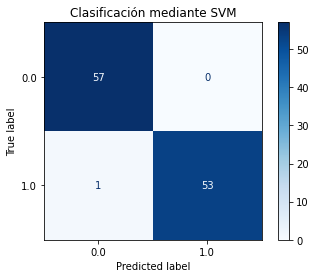

In [ ]:
cm = plot_confusion_matrix(clf, X_test_scaled, y_test, cmap='Blues')
cm.ax_.set_title('Clasificación mediante SVM')
plt.savefig('SVM_normal.png')
plt.show()

GridSearch para SVM. Busqueda de Kernels.

In [ ]:
svm_clf = SVC()
grid_kernels = {'kernel':('linear', 'poly', 'rbf', 'sigmoid')}
svm_grid = GridSearchCV(svm_clf, grid_kernels, scoring='accuracy', verbose=1)
svm_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [ ]:
y_pred = svm_grid.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print('Accuracy system: ' + str(acc))

Accuracy system: 0.990990990990991


#### Matriz de confusión.

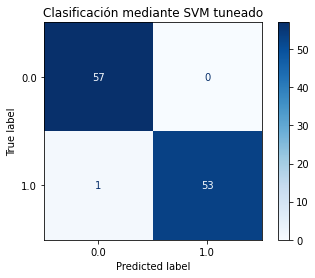

In [ ]:
cm = plot_confusion_matrix(svm_grid, X_test_scaled, y_test, cmap='Blues')
cm.ax_.set_title('Clasificación mediante SVM tuneado')
plt.savefig('SVM_tunned.png')
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print('Accuracy system: ' + str(acc))

Accuracy system: 0.9369369369369369


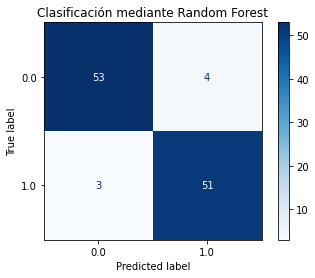

In [ ]:
cm = plot_confusion_matrix(rf, X_test_scaled, y_test, cmap='Blues')
cm.ax_.set_title('Clasificación mediante Random Forest')
plt.savefig('RF.png')
plt.show()